In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import keras

In [11]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [12]:
parent_folder_path = "Dataset"

In [13]:
## Organizing the dataset into a df
image_paths = []
class_labels = []
class_label_map = {}

#iterating the subfolders
for subfolder_name in os.listdir(parent_folder_path):
    #extracting the class labels and names
    class_label = int(subfolder_name.split(".")[0]) - 1
    class_label_map[class_label] = subfolder_name.split(".")[1].split(" ")[1]
    #contructing image paths and labels
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    for image_name in os.listdir(subfolder_path):
         image_path = os.path.join(subfolder_path, image_name)
         image_paths.append(image_path)
         class_labels.append(class_label)

#creating a dataframe
data = {"image_path": image_paths, "class_label": class_labels}
df = pd.DataFrame(data)

class_label_map

{0: 'Eczema',
 9: 'Warts',
 1: 'Melanoma',
 2: 'Atopic',
 3: 'Basal',
 4: 'Melanocytic',
 5: 'Benign',
 6: 'Psoriasis',
 7: 'Seborrheic',
 8: 'Tinea'}

In [14]:
df

,image_path,class_label
0,Dataset\1. Eczema 1677\0_0.jpg,0
1,Dataset\1. Eczema 1677\0_1.jpg,0
2,Dataset\1. Eczema 1677\0_10.jpg,0
3,Dataset\1. Eczema 1677\0_11.jpg,0
4,Dataset\1. Eczema 1677\0_12.jpg,0
...,...,...
27148,Dataset\9. Tinea Ringworm Candidiasis and othe...,8
27149,Dataset\9. Tinea Ringworm Candidiasis and othe...,8
27150,Dataset\9. Tinea Ringworm Candidiasis and othe...,8
27151,Dataset\9. Tinea Ringworm Candidiasis and othe...,8


In [15]:
## Counting the images in each class
data_dir = 'Dataset'
class_names = os.listdir(parent_folder_path)

for class_name in class_names:
    class_dir = os.path.join(parent_folder_path, class_name)
    num_images = len(os.listdir(class_dir))
    print("Class {}: {} images".format(class_name, num_images))

Class 1. Eczema 1677: 1677 images
Class 10. Warts Molluscum and other Viral Infections - 2103: 2103 images
Class 2. Melanoma 15.75k: 3140 images
Class 3. Atopic Dermatitis - 1.25k: 1257 images
Class 4. Basal Cell Carcinoma (BCC) 3323: 3323 images
Class 5. Melanocytic Nevi (NV) - 7970: 7970 images
Class 6. Benign Keratosis-like Lesions (BKL) 2624: 2079 images
Class 7. Psoriasis pictures Lichen Planus and related diseases - 2k: 2055 images
Class 8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 1847 images
Class 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 1702 images


<Axes: xlabel='class_label'>

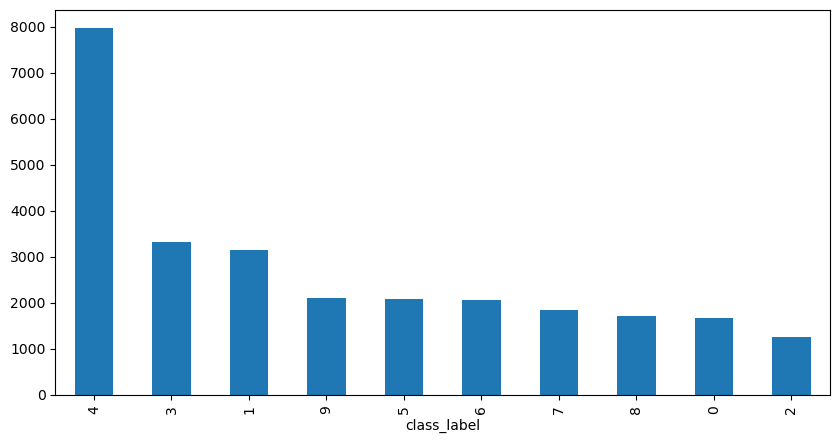

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_label'].value_counts().plot(kind='bar', ax=ax1)

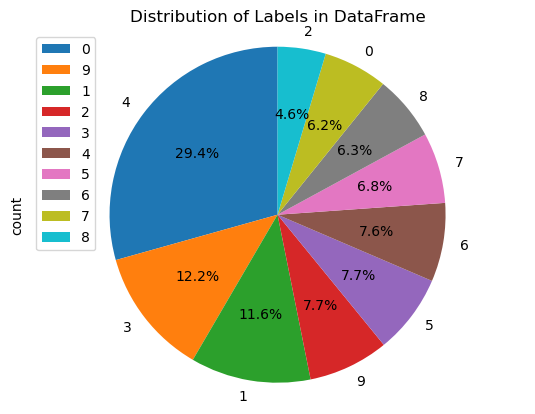

In [17]:
df['class_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['class_label'].unique())
plt.show()

In [18]:
## Optimizing the dataset
max_images_per_class = 2000
#Group by label column and take first max_images_per_class rows for each group
df = df.groupby("class_label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_10440\624427050.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("class_label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


<Axes: xlabel='class_label'>

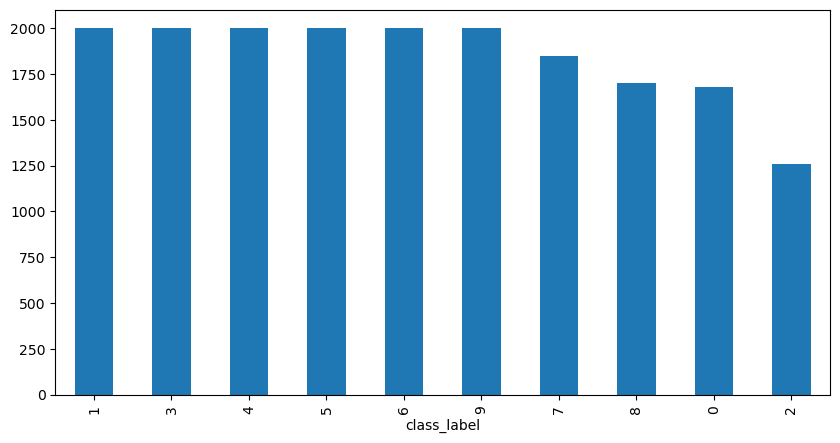

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_label'].value_counts().plot(kind='bar', ax=ax1)

In [21]:
#CPU cores available
import concurrent.futures
import multiprocessing
max_workers = multiprocessing.cpu_count()
max_workers

12

In [ ]:
## Resizing images, converting them into numpy arrays, and adding them to a df
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays
df

,image_path,class_label,image
0,Dataset\1. Eczema 1677\0_0.jpg,0,"[[[143, 135, 130], [149, 138, 134], [151, 144,..."
1,Dataset\1. Eczema 1677\0_1.jpg,0,"[[[196, 135, 118], [198, 137, 125], [197, 139,..."
2,Dataset\1. Eczema 1677\0_10.jpg,0,"[[[91, 59, 58], [93, 64, 60], [99, 60, 57], [1..."
3,Dataset\1. Eczema 1677\0_11.jpg,0,"[[[91, 95, 106], [90, 94, 104], [91, 95, 104],..."
4,Dataset\1. Eczema 1677\0_12.jpg,0,"[[[141, 80, 62], [149, 83, 66], [156, 88, 70],..."
...,...,...,...
18478,Dataset\10. Warts Molluscum and other Viral In...,9,"[[[19, 9, 8], [19, 9, 7], [19, 9, 6], [19, 9, ..."
18479,Dataset\10. Warts Molluscum and other Viral In...,9,"[[[27, 16, 13], [25, 14, 11], [26, 14, 12], [2..."
18480,Dataset\10. Warts Molluscum and other Viral In...,9,"[[[110, 92, 70], [113, 93, 68], [113, 91, 68],..."
18481,Dataset\10. Warts Molluscum and other Viral In...,9,"[[[133, 93, 60], [134, 94, 62], [137, 100, 72]..."


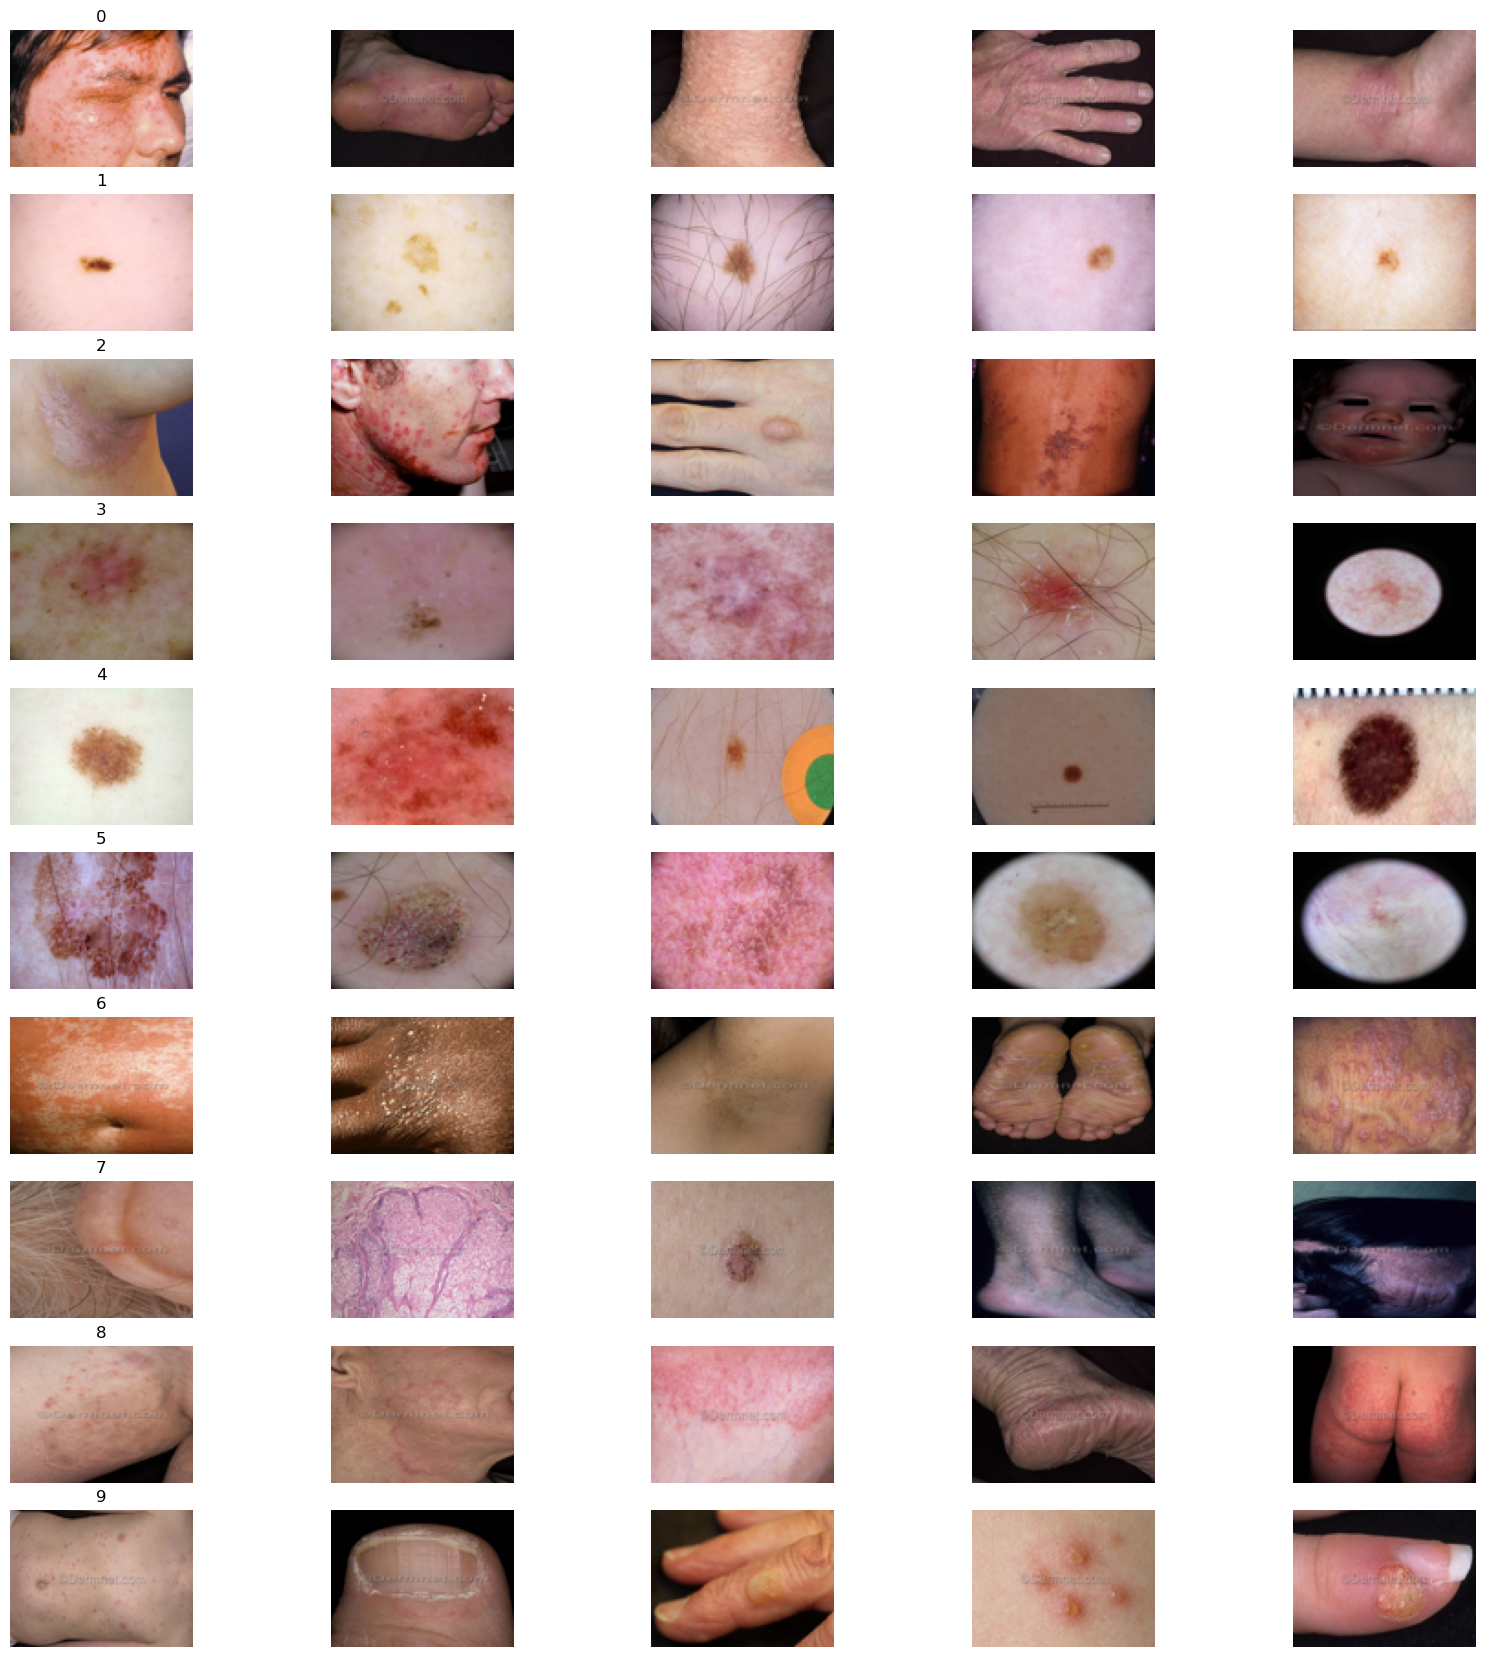

In [14]:
n_samples = 5
fig, m_axs = plt.subplots(10, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['class_label']).groupby('class_label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [15]:
## rechecking the size
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    18483
Name: count, dtype: int64

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [17]:
# performing data augmentation by generating additional images for each class and ensuring each class has fixed number of images
augmented_data = []

# Loop through each class label and generate additional images if needed
for class_label in df['class_label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['class_label'] == class_label, 'image'].values
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed, replace=True)
        # Apply transformations to the selected images
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            # Extract one augmented image from the generator
            augmented_image_array = next(augmented_images)[0].astype('uint8')
            # Add the augmented image to the list
            augmented_data.append({'image_path': None, 'class_label': class_label, 'image': augmented_image_array})
    
    # Add the original images for the current class to the list
    original_images = df.loc[df['class_label'] == class_label, ['image_path', 'class_label', 'image']].to_dict(orient='records')
    augmented_data.extend(original_images)

# Create the augmented dataframe
augmented_df = pd.DataFrame(augmented_data)

# Group the augmented DataFrame by the 'class_label' column and filter out extra images
df = augmented_df.groupby('class_label').head(max_images_per_class).sample(frac=1, random_state=42).reset_index(drop=True)

# Clean up memory
del augmented_data


In [18]:
df.groupby('class_label').size()

class_label
0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
7    2000
8    2000
9    2000
dtype: int64

In [19]:
##Counting the number of images in each class
class_counts = df['class_label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 50)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 50)
for class_label, class_name in class_label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 50)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
--------------------------------------------------
Class Label     Class Name                     Count     
--------------------------------------------------
0               Eczema                         2000      
9               Warts                          2000      
1               Melanoma                       2000      
2               Atopic                         2000      
3               Basal                          2000      
4               Melanocytic                    2000      
5               Benign                         2000      
6               Psoriasis                      2000      
7               Seborrheic                     2000      
8               Tinea                          2000      
--------------------------------------------------
Total                                         20000     


In [21]:
## dropping features class_label and image path from df
features=df.drop(columns=['class_label','image_path'],axis=1)
target=df['class_label']

In [22]:
target.head()

0    5
1    1
2    4
3    0
4    6
Name: class_label, dtype: int64

In [23]:
print(target.shape,features.shape)

(20000,) (20000, 1)


In [24]:
##spliting the dataset into training and testing sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [25]:
##preprocessing the image data by converting images into numpy arrays and normalizing them
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [26]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o,num_classes = 10)
y_test = to_categorical(y_test_o,num_classes = 10)

In [27]:
# spliting the training data into two subsets: one for training and one for validation
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [28]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Define data augmentation parameters
datagen = ImageDataGenerator(
         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
         zoom_range = 0.1, # Randomly zoom image 
         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
         shear_range=0.2, # Shear angle in counter-clockwise direction in degrees
 )

# Prepare the data generators
train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = datagen.flow(x_validate, y_validate, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1767304887763887..1.9826305845053578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1767304..1.9676291].


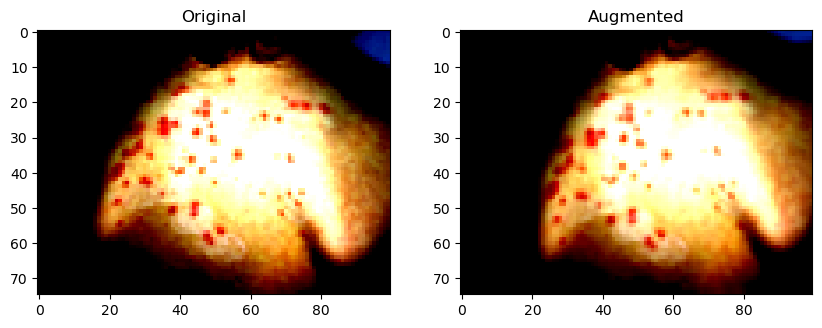

In [30]:
## side by side demonstration of data augmentation on an image
import matplotlib.pyplot as plt
import random
import numpy as np

# Get an image from the training data
img = x_train[random.randint(0, len(x_train))]
# Add an extra dimension to the image so that it has shape (1, height, width, channels)
img = np.expand_dims(img, axis=0)
# Create a generator to apply data augmentation to the image
aug_gen = datagen.flow(img, batch_size=1)
# Generate an augmented version of the image
aug_img = next(aug_gen)[0]
# Plot the original image and its augmented version
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(img[0])
axs[0].set_title('Original')
axs[1].imshow(aug_img)
axs[1].set_title('Augmented')
plt.show()

In [31]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

# Number of classes
num_classes = 10
input_shape = (75, 100, 3)

# Initialize DenseNet121 as the base model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)

# Build the model
model = Sequential()
model.add(base_model)  # Add the pre-trained DenseNet121 model
model.add(GlobalAveragePooling2D())  # Use global average pooling instead of Flatten for better performance
model.add(Dense(512, activation='relu'))  # Fully connected layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Define optimizer
opt = SGD(learning_rate=0.001, momentum=0.9)  # Use `learning_rate` instead of `lr`

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 2, 3, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,567,434 (28.87 MB)

 Trainable params: 7,483,786 (28.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [33]:
epochs = 50
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1334s 3s/step - accuracy: 0.4008 - loss: 1.6700 - val_accuracy: 0.6181 - val_loss: 1.0347 - learning_rate: 0.0010
Epoch 2/50


c:\Users\bhavy\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


450/450 ━━━━━━━━━━━━━━━━━━━━ 1250s 3s/step - accuracy: 0.6830 - loss: 0.8682 - val_accuracy: 0.6525 - val_loss: 0.9773 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1271s 3s/step - accuracy: 0.7895 - loss: 0.5974 - val_accuracy: 0.6825 - val_loss: 0.9059 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1256s 3s/step - accuracy: 0.8560 - loss: 0.4224 - val_accuracy: 0.6869 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1254s 3s/step - accuracy: 0.9027 - loss: 0.2824 - val_accuracy: 0.6931 - val_loss: 1.0892 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 5868s 13s/step - accuracy: 0.9339 - loss: 0.2038 - val_accuracy: 0.6787 - val_loss: 1.1114 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1255s 3s/step - accuracy: 0.9549 - loss: 0.1507 - val_accuracy: 0.7106 - val_loss: 1.0881 - learning_rate: 0.0010
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1263s 3s/step - accuracy: 0.9587 - loss: 0.130

125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 758ms/step


<Axes: >

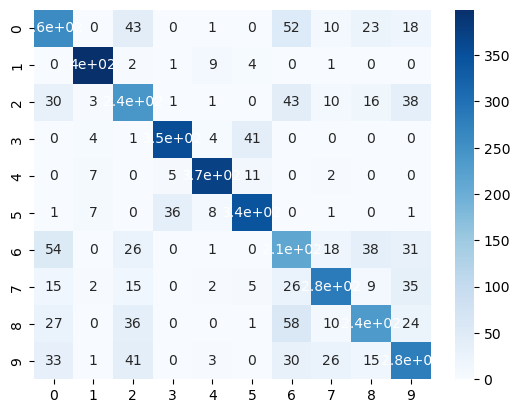

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.7458
Precision: 0.7468
Recall: 0.7440
F1-score: 0.7447
Kappa score: 0.7175


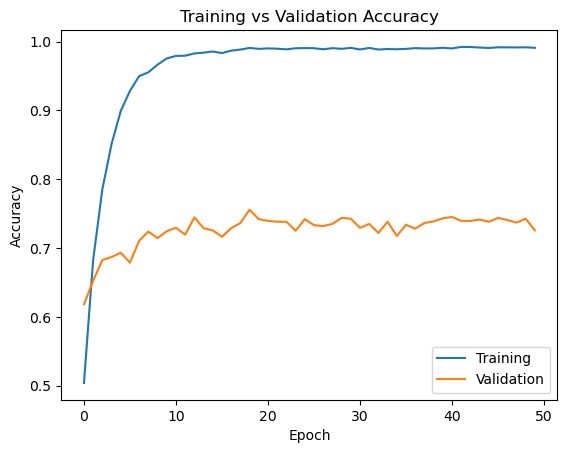

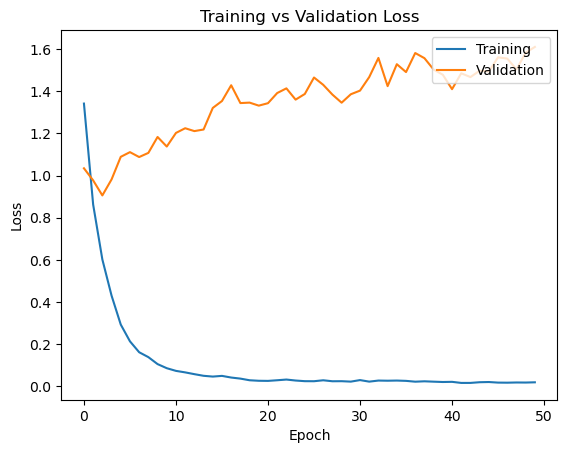

In [36]:
import matplotlib.pyplot as plt

# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()
# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [37]:
model.save("model.keras")